In [1]:
pip install pyimkernel

In [2]:
pip install mnist

In [3]:
import mnist
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from pyimkernel import ApplyKernels
import zipfile
!unzip /content/mnist.zip

Archive:  /content/mnist.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [4]:
X_train, X_test, y_train, y_test = mnist.train_images(), mnist.test_images(), mnist.train_labels(), mnist.test_labels()

In [6]:
X_train.shape

(60000, 28, 28)

In [7]:
X_test.shape

(10000, 28, 28)

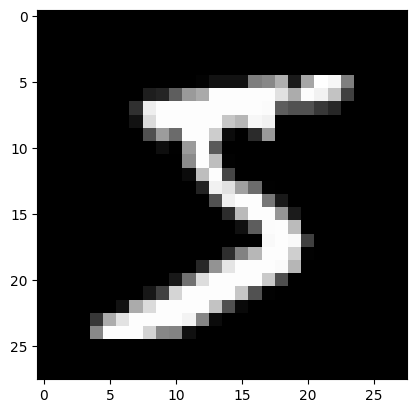

In [8]:
plt.imshow(X_train[0], cmap=plt.cm.gray)

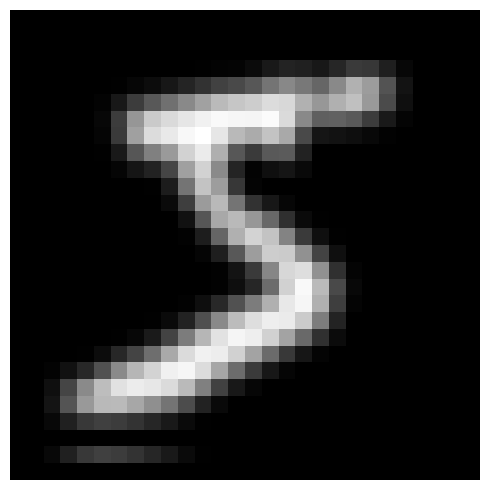

In [9]:
imkernel = ApplyKernels(random_seed=0)
imkernel.imshow(image=imkernel.apply_filter_on_gray_img(X_train[0], kernel_name='blur'),
cmap=plt.cm.gray)

In [10]:
def pixel_normalization(image):
  return (image / 255)
X_train = pixel_normalization(X_train)
X_test = pixel_normalization(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [11]:
X_train.shape

(60000, 28, 28, 1)

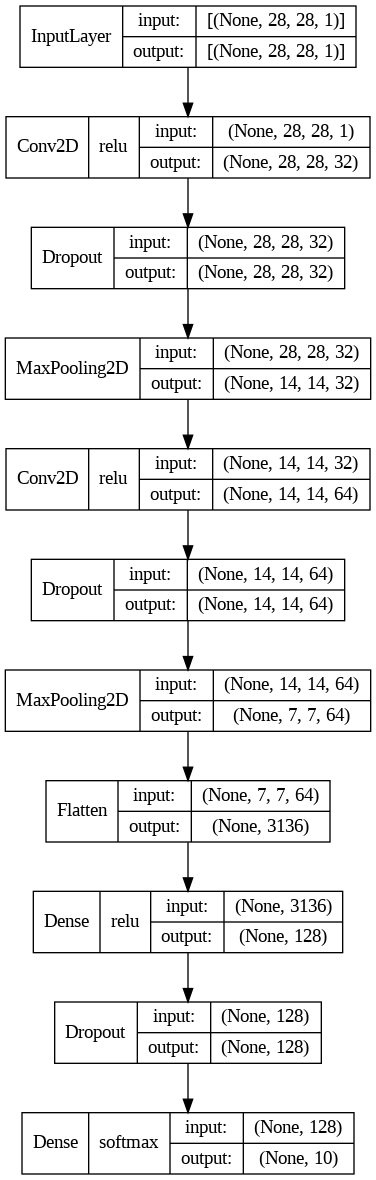

In [12]:
cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(28, 28, 1)))
cnn.add(Dropout(.2))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu'))
cnn.add(Dropout(.2))
cnn.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(units=10, activation='softmax'))
plot_model(cnn, show_shapes=True, show_layer_activations=True, show_layer_names=False)

In [13]:
cnn.compile(optimizer=Adam(learning_rate=0.001),
loss=CategoricalCrossentropy(from_logits=True),
metrics=CategoricalAccuracy())
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='/kaggle/working/model_weights.h5', monitor='val_categorical_accuracy', save_best_only=True)
history = cnn.fit(X_train, y_train, epochs=10, batch_size=200, validation_data=(X_test, y_test), callbacks=[checkpoint, reduce_lr])

Epoch 1/10
300/300 [==============================] - 97s 316ms/step - loss: 0.3232 - categorical_accuracy: 0.8997 - val_loss: 0.0792 - val_categorical_accuracy: 0.9789 - lr: 0.0010
Epoch 2/10
300/300 [==============================] - 90s 300ms/step - loss: 0.1006 - categorical_accuracy: 0.9707 - val_loss: 0.0501 - val_categorical_accuracy: 0.9850 - lr: 0.0010
Epoch 3/10
300/300 [==============================] - 92s 306ms/step - loss: 0.0727 - categorical_accuracy: 0.9786 - val_loss: 0.0412 - val_categorical_accuracy: 0.9873 - lr: 0.0010
Epoch 4/10
300/300 [==============================] - 87s 290ms/step - loss: 0.0615 - categorical_accuracy: 0.9825 - val_loss: 0.0388 - val_categorical_accuracy: 0.9886 - lr: 0.0010
Epoch 5/10
300/300 [==============================] - 86s 286ms/step - loss: 0.0545 - categorical_accuracy: 0.9841 - val_loss: 0.0327 - val_categorical_accuracy: 0.9903 - lr: 0.0010
Epoch 6/10
300/300 [==============================] - 88s 295ms/step - loss: 0.0458 - cate

In [14]:
y_pred = cnn.predict(X_test)
y_pred

313/313 [==============================] - 5s 14ms/step


array([[4.8449850e-10, 1.0612249e-06, 1.2569159e-06, ..., 9.9999195e-01,
        6.3291417e-08, 5.2774903e-06],
       [1.4857379e-07, 1.0257367e-05, 9.9998862e-01, ..., 6.0984937e-09,
        2.6060357e-08, 1.9841062e-09],
       [2.6905395e-08, 9.9994439e-01, 1.8397016e-06, ..., 4.9144405e-06,
        4.8743177e-06, 1.4726872e-07],
       ...,
       [2.3232618e-14, 2.4768396e-09, 1.9435456e-12, ..., 2.0679696e-09,
        3.8684849e-08, 8.6053113e-08],
       [1.3078225e-08, 2.1243316e-09, 2.3469920e-10, ..., 8.8288786e-11,
        1.8764987e-04, 2.6110405e-08],
       [1.1200162e-06, 2.5110380e-08, 9.2172868e-08, ..., 3.0798121e-11,
        6.6610269e-06, 4.5682345e-08]], dtype=float32)

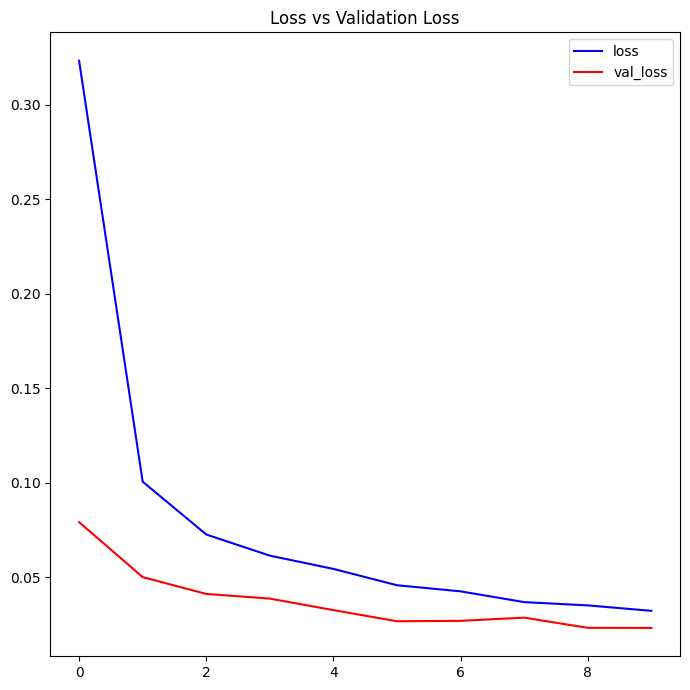

In [15]:
predictions = []
for instance in y_pred:
   predictions.append(np.argmax(instance))
plt.figure(figsize=(7, 7))
plt.plot(history.history['loss'], color='blue', label='loss');
plt.plot(history.history['val_loss'], color='red', label='val_loss');
plt.legend();
plt.title('Loss vs Validation Loss');
plt.tight_layout()

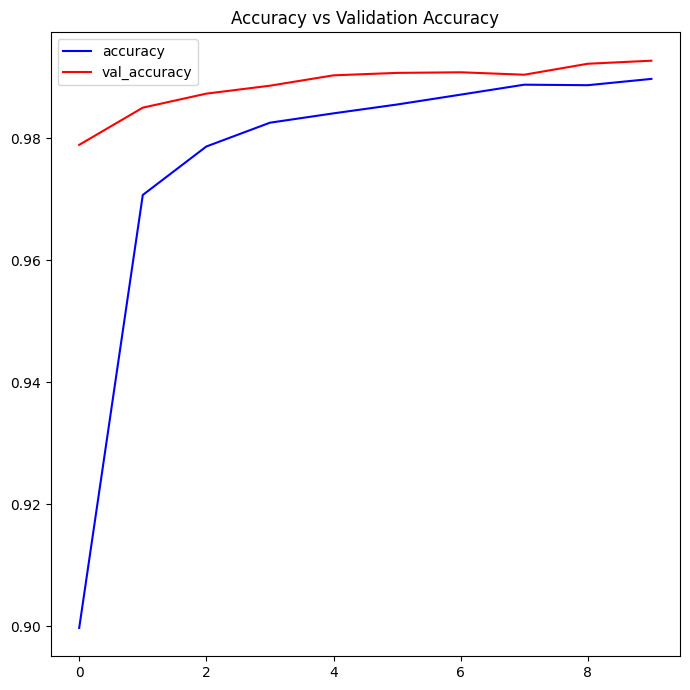

In [16]:
plt.figure(figsize=(7, 7))
plt.plot(history.history['categorical_accuracy'], color='blue', label='accuracy');
plt.plot(history.history['val_categorical_accuracy'], color='red', label='val_accuracy');
plt.legend();
plt.title('Accuracy vs Validation Accuracy');
plt.tight_layout()